In [5]:
import skimage
import lib.coco_handler as ch
import os
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage import measure, morphology
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
from PIL import Image

import lib.constants as constants
from lib.coco_handler import *
from lib.copy_and_paste_augm import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create a new COCO annotation set from masks

This chunks takes an existing annotation file (alternatively creates an empty on)
 and adds instance masks extracted from the binary masks.

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


C:\Users\sebas\.conda\envs\pg\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 33434
  "Possibly corrupt EXIF data.  "
C:\Users\sebas\.conda\envs\pg\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 33437
  "Possibly corrupt EXIF data.  "
C:\Users\sebas\.conda\envs\pg\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 0. Skipping tag 36867
  "Possibly corrupt EXIF data.  "
C:\Users\sebas\.conda\envs\pg\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 0. Skipping tag 36868
  "Possibly corrupt EXIF data.  "
C:\Users\sebas\.conda\envs\pg\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes bu

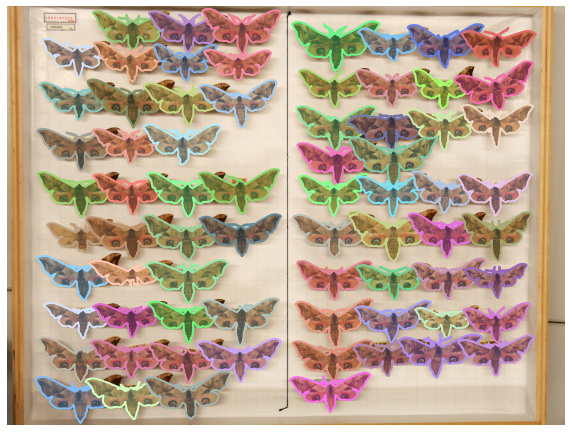

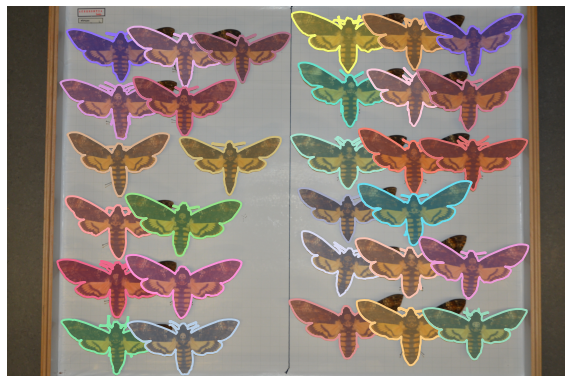

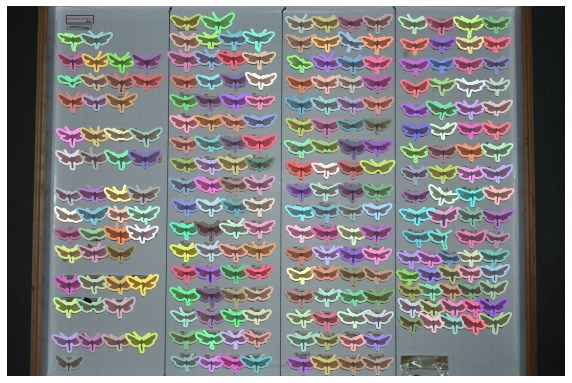

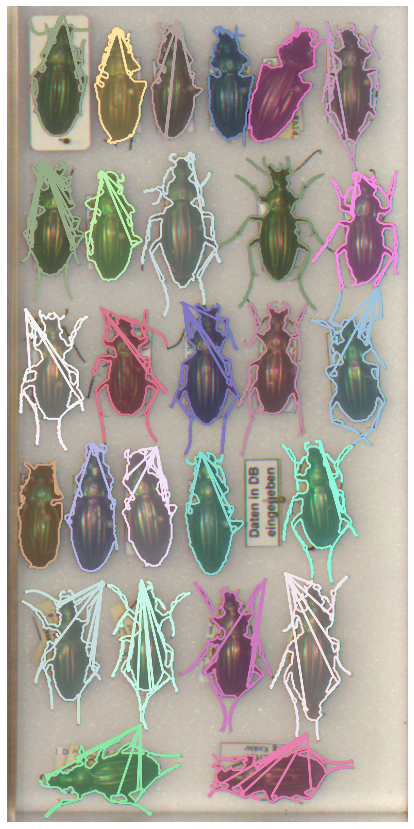

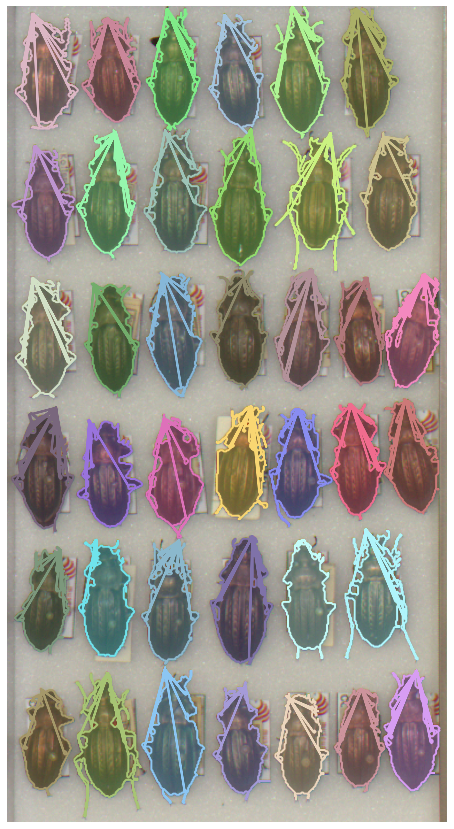

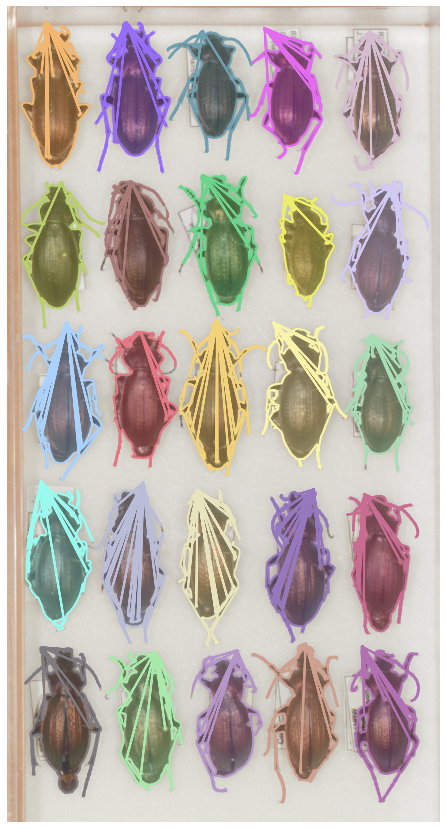

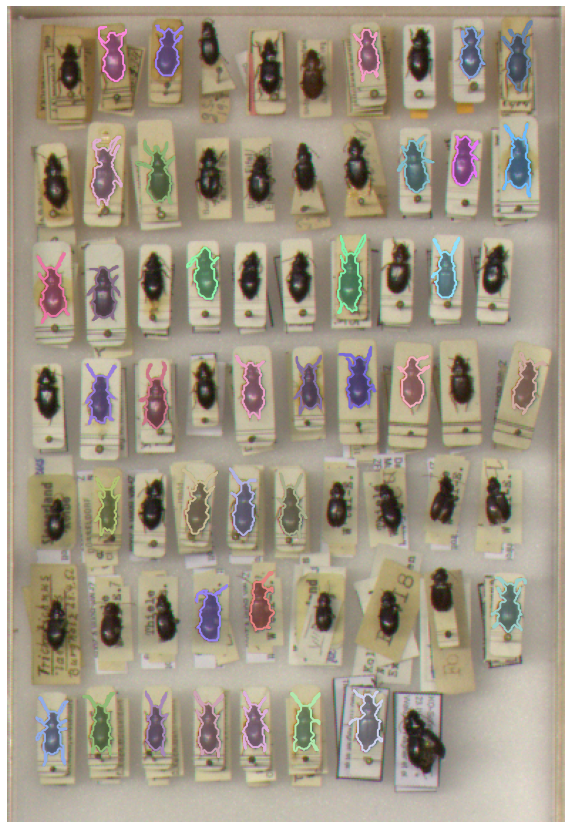

'{"info": {"description": "Data set for segmenting insects", "url": "url", "version": "v0.0.0", "year": "2021", "contributor": ["Sebastian Rassmann"], "date_created": "2021/04/27-00:00:00"}, "categories": [{"id": 1, "name": "Mesembryhmus purpuralis", "supercategory": "Butterfly"}, {"id": 2, "name": "Smerinthus ocellata", "supercategory": "Butterfly"}, {"supercategory": "bug", "id": 3, "name": "bug"}], "images": [{"id": 0, "file_name": "Smerinthus_ocellata.jpg", "width": 5184, "height": 3888, "date_captured": "2021-03-28 22:10:50.716292", "license": 1, "coco_url": "", "flickr_url": ""}, {"id": 1, "file_name": "DSC_6754.JPG", "width": 4928, "height": 3264, "date_captured": "2021-03-28 22:10:50.716292", "license": 1, "coco_url": "", "flickr_url": ""}, {"id": 2, "file_name": "Mesembryhnus_purpuralis.JPG", "width": 4928, "height": 3264, "date_captured": "2021-03-28 22:10:50.716292", "license": 1, "coco_url": "", "flickr_url": ""}, {"img_license": 1, "file_name": "bug_2.tif", "height": 766, 

In [5]:
c_raw = coco_dataset(os.path.join(constants.path_to_anno_dir, "butterfly_anno.json"))
d = os.path.join(constants.path_to_data_dir, "raw", "bug_labelling.csv")
d = pd.read_csv(d)
for _, row in d.iterrows():
    c_raw.add_annotation_from_binary_mask(
        os.path.join(constants.path_to_masks_dir, row["mask"]),
        row["crop_image_name"],
        row["rough_class"],
        row["rough_class"],
        min_area=row["min_area"],
    )
c_raw.show_annotations()
c_raw.to_json(os.path.join(constants.path_to_anno_dir, "all_anno.json"))


Now in the file `all_anno.json` all annotations are combined.

# Extract single objects from masks

In [7]:
coco = COCO(os.path.join(constants.path_to_anno_dir, "all_anno.json"))
pc = PatchCreator(constants.path_to_imgs_dir,
                  os.path.join(constants.path_to_output_dir, "patches"), coco, False)
for img in coco.imgs.values():
    pc(img, dilation=3)
print("average sizes dictionary:")
print(pc.average_sizes)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


100%|██████████| 36/36 [00:00<00:00, 365.32it/s]


{'Mesembryhmus purpuralis': (316.79715302491087, 192.3629893238434),
 'Smerinthus ocellata': (655.6478873239437, 379.9718309859156),
 'bug': (83.76377952755905, 162.09448818897638)}

This created a folder for each object category and placed the individual objects inside.

You might now want to filter the images for bad quality, partially occluded images etc.

In [4]:
cpg_coco_train = coco_dataset(info=coco_dataset.create_coco_info(descr="""
    Image set create by Copy and Paste data augmentation
""", contrib="Sebastian Rassmann"))

# patch_sizes = pc.average_sizes
patch_sizes = {'Mesembryhmus purpuralis': (316.79715302491087, 192.3629893238434),
 'Smerinthus ocellata': (655.6478873239437, 379.9718309859156),
 'bug': (83.76377952755905, 162.09448818897638)}

n_collection_boxes = 3
n_random = 2


In [ ]:
cpg = CopyPasteGenerator(patch_sizes,
                         os.path.join(constants.path_to_copy_and_paste, "objs"),
                         os.path.join(constants.path_to_copy_and_paste, "backgrounds")
                         )

In [ ]:
for i in tqdm(range(n_collection_boxes)):
    img, mask, cats = cpg.generate_collection_box()
    img_name = f"train-col-{i}.png"
    io.imsave(os.path.join(
        constants.path_to_copy_and_paste, "output", "train", img_name),
            (img*255).astype(np.uint8)
        )
    cpg_coco_train.add_annotations_from_instance_mask(mask, img_name, cats)
    if i+1 % n_collection_boxes // 2 == 0:
        cpg.change_background("collection_box2.tif")

In [ ]:
cpg.change_background("collection_box.tif")
for i in tqdm(range(n_random)):
    img, mask, cats = cpg.generate_random(np.random.randint(10,20))
    img_name = f"train-rand-{i}.png"
    io.imsave(os.path.join(
        constants.path_to_copy_and_paste, "output", "train", img_name),
            (img*255).astype(np.uint8)
        )
    cpg_coco_train.add_annotations_from_instance_mask(mask, img_name, cats)

cpg_coco_train.to_json(os.path.join(
    constants.path_to_copy_and_paste, "output", "train", "cp_train.json"))

In [6]:
def f():
    img, mask, cats = cpg.generate_collection_box()

In [7]:
import pstats
import cProfile

In [10]:
profile = cProfile.Profile()
profile.runcall(cpg.generate_collection_box)
ps = pstats.Stats(profile)
ps.sort_stats('cumtime')
ps.print_stats()

         24862 function calls (24148 primitive calls) in 0.901 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    0.901    0.901 C:\Users\sebas\Documents\PG ISS SS21\pg iss\lib\copy_and_paste_augm.py:173(generate_collection_box)
       93    0.494    0.005    0.572    0.006 C:\Users\sebas\Documents\PG ISS SS21\pg iss\lib\copy_and_paste_augm.py:314(_place_obj_on_image)
      102    0.001    0.000    0.183    0.002 C:\Users\sebas\Documents\PG ISS SS21\pg iss\lib\copy_and_paste_augm.py:351(_rescale_obj)
  204/102    0.002    0.000    0.179    0.002 C:\Users\sebas\.conda\envs\pg\lib\site-packages\PIL\Image.py:1844(resize)
      102    0.148    0.001    0.148    0.001 {method 'resize' of 'ImagingCore' objects}
  909/297    0.079    0.000    0.123    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       93    0.000    0.000    0.078    0.001 <__array_function__ internal

In [18]:
def f():
    for _ in range(10):
        img, mask, cats = cpg.generate_collection_box()

In [6]:
%load_ext snakeviz

In [22]:
patch_sizes = {'Mesembryhmus purpuralis': (316.79715302491087, 192.3629893238434),
 'Smerinthus ocellata': (655.6478873239437, 379.9718309859156),
 'bug': (83.76377952755905, 162.09448818897638)}
cpg = CopyPasteGenerator(patch_sizes,
                         os.path.join(constants.path_to_copy_and_paste, "objs"),
                         os.path.join(constants.path_to_copy_and_paste, "backgrounds")
                         )

def f():
    img_name = "sd.pnd"
    for _ in range(100):
        img, mask, cats = cpg.generate_collection_box_2()
        print(img.shape)
        print(len(mask))
#         cpg_coco_train.add_annotations_from_instance_mask(mask, img_name, cats)

In [21]:
%snakeviz f()

 
*** Profile stats marshalled to file 'C:\\Users\\sebas\\AppData\\Local\\Temp\\tmpwirbgxv8'. 
Embedding SnakeViz in this document...


In [23]:
%snakeviz f()

(2650, 2625, 3)
2650
(2576, 2522, 3)
2576
(2658, 2659, 3)
2658
(2103, 2213, 3)
2103
(2022, 2046, 3)
2022
(3105, 3129, 3)
3105
(2603, 2399, 3)
2603
(3485, 3264, 3)
3485
(2989, 3081, 3)
2989
(2104, 2107, 3)
2104
(2140, 2159, 3)
2140
(2547, 2487, 3)
2547
(3247, 3155, 3)
3247
(2495, 2402, 3)
2495
(3139, 3057, 3)
3139
(2717, 2670, 3)
2717
(2172, 2188, 3)
2172
(3409, 3124, 3)
3409
(3187, 3170, 3)
3187
(2053, 2011, 3)
2053
(2252, 2017, 3)
2252
(2302, 2136, 3)
2302
(2981, 2891, 3)
2981
(2395, 2412, 3)
2395
(2390, 2272, 3)
2390
(2058, 2196, 3)
2058
(3383, 2956, 3)
3383
(2729, 2792, 3)
2729
(3433, 3392, 3)
3433
(2702, 2573, 3)
2702
(2974, 3066, 3)
2974
(2984, 2887, 3)
2984
(2815, 2877, 3)
2815
(2540, 2340, 3)
2540
(2316, 2417, 3)
2316
(2643, 2737, 3)
2643
(3234, 3142, 3)
3234
(3390, 3309, 3)
3390
(3038, 2918, 3)
3038
(2769, 2945, 3)
2769
(2735, 2544, 3)
2735
(3196, 3140, 3)
3196
(3317, 3324, 3)
3317
(3236, 3008, 3)
3236
(2581, 2400, 3)
2581
(2471, 2481, 3)
2471
(2843, 2600, 3)
2843
(3029, 2881, 